## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [80]:
%matplotlib inline
from time import time, sleep
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
plt.style.use('ggplot')

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

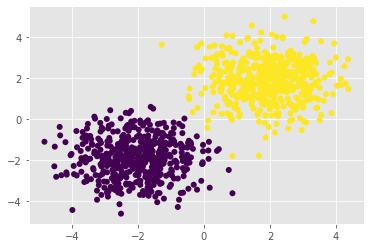

In [46]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [47]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [48]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [49]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

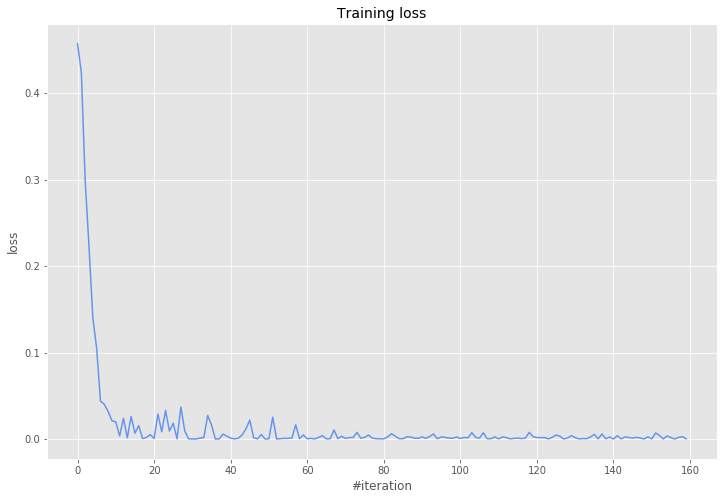

Current loss: 0.000258


In [50]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 8))
        
    plt.title("Training loss", fontsize=14)
    plt.xlabel("#iteration", fontsize=12)
    plt.ylabel("loss", fontsize=12)
    plt.plot(loss_history, 'b', color='cornflowerblue')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
def one_hot(y):
    u = np.unique(y).size
    oh = np.zeros((y.size, u))
    oh[range(y.size), y] = 1
    return oh

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
y_train_orig, y_val_orig, y_test_orig = y_train, y_val, y_test
y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

## Comparison

### Different activation functions

Let's define a model and try out __different activation functions__, then plot corresponding losses.

In [12]:
def train_model(net, epochs, optimizer_config, x, y, batch_size=128, optimizer=sgd_momentum):
    optimizer_state = {}
    criterion = ClassNLLCriterion()
    losses = []
    
    for i in range(epochs):
        
        net.train()
        for x_batch, y_batch in get_batches((x, y), batch_size):
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            
            losses.append(loss)
            
    return losses

In [13]:
def make_clf_net(activation):
    net = Sequential()
    net.add(Linear(28*28, 400))
    net.add(activation())
    net.add(Linear(400, 10))
    net.add(LogSoftMax())
    return net

In [14]:
activations = (ReLU, LeakyReLU, ELU, SoftPlus)

In [15]:
%%time
all_losses = []
for activation in activations:
    net = make_clf_net(activation)
    losses = train_model(net, 10, optimizer_config, X_train.reshape(len(X_train), -1), y_train, batch_size=2000)
    all_losses.append(losses)

CPU times: user 35min 9s, sys: 20min 59s, total: 56min 9s
Wall time: 30min 6s


In [16]:
def plot_losses(all_losses, labels, title=''):
    plt.figure(figsize=(15, 10))
    for losses, label in zip(all_losses, labels):
        plt.plot(losses, label=label)
    plt.xlabel('Batch number', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().set_yscale('log')
    plt.legend(fontsize=12)
    plt.show()

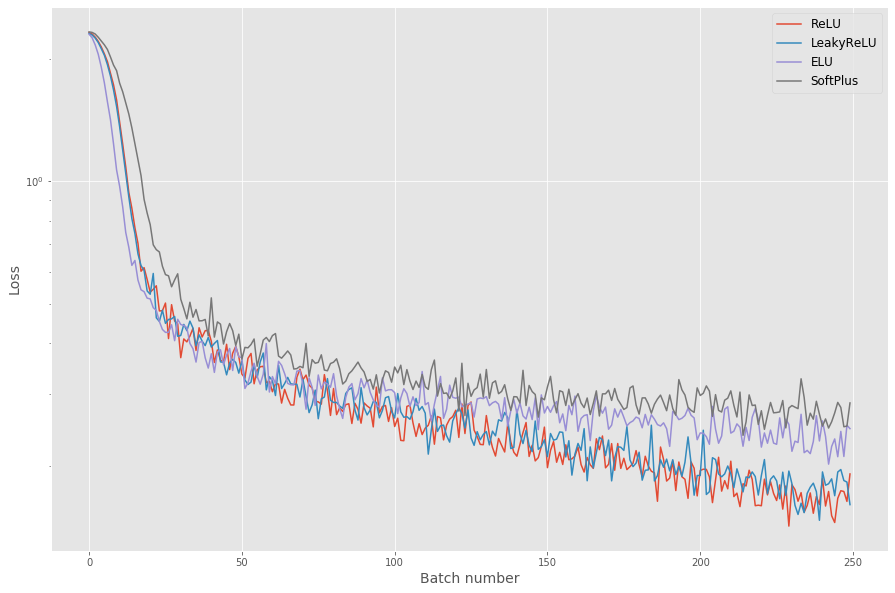

In [17]:
plot_losses(all_losses, (act.__name__ for act in activations))

### Adding BatchNormalization and ChannelwiseScaling

Let's try inserting __BatchNormalization__, followed by __ChannelwiseScaling__, between __Linear__ module and activation functions. Then we will plot obtained loss in comparison to the results above.

In [18]:
def make_clf_net_batch_norm(activation):
    net = Sequential()
    net.add(Linear(28*28, 400))
    net.add(BatchNormalization(0.9))
    net.add(ChannelwiseScaling(400))
    net.add(activation())
    net.add(Linear(400, 10))
    net.add(LogSoftMax())
    return net

In [19]:
%%time
net = make_clf_net_batch_norm(LeakyReLU)
batch_loss = train_model(net, 10, optimizer_config, X_train.reshape(len(X_train), -1), y_train, batch_size=2000)

CPU times: user 8min 44s, sys: 5min 3s, total: 13min 47s
Wall time: 7min 37s


In [25]:
new_losses = all_losses.copy()
new_losses.append(batch_loss)

In [26]:
new_labels = ('ReLU', 'LeakyReLU', 'ELU', 'SoftPlus', 'BatchNormalization + LeakyReLU')

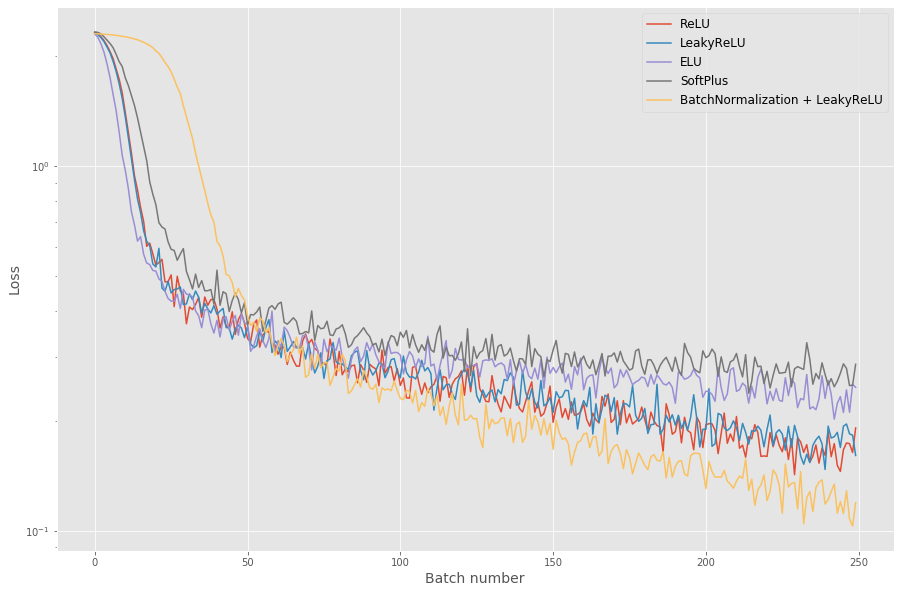

In [27]:
plot_losses(new_losses, new_labels)

### Optimizers comparison

Let's compare two optimizers: __momentum_sgd__ and __Adam__. I'll use the last model with __BatchNormalization__ and __ChannelwiseScaling__ as a base network. We already have results for __momentum_sgd__, so let's work with __Adam__.

In [51]:
adam_optimizer_config = {'learning_rate': 3e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
adam_optimizer_state = {}

In [52]:
%%time
net = make_clf_net_batch_norm(LeakyReLU)
adam_loss = train_model(net, 10, adam_optimizer_config, 
                        X_train.reshape(len(X_train), -1), y_train,
                        batch_size=2000, optimizer=adam_optimizer)

CPU times: user 8min 15s, sys: 4min 57s, total: 13min 12s
Wall time: 6min 53s


In [53]:
optimizers_losses = []
optimizers_losses.append(batch_loss)
optimizers_losses.append(adam_loss)

In [54]:
optimizers_labels = ('Momentum SGD', 'Adam')

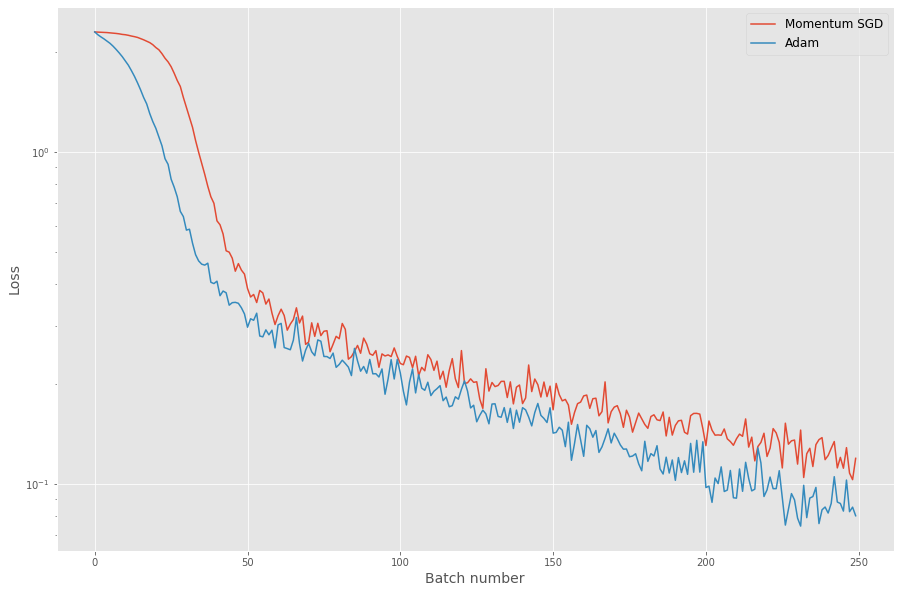

In [55]:
plot_losses(optimizers_losses, optimizers_labels)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In this task activation functions allowed to get close results due to the plots. Anyway, the computation time for __ReLU__ and __LeakyReLU__ should be much less, because they are simply faster to compute because of the absence of __exp__ computations. Moreover, __BatchNormalization__ helps to converge faster starting with a certain number of used batches. It's hard to say something accurate about optimizers. In the graph above we see that __Adam__ performed slightly better than __momentum_sgd__, but it depends on optimizer's parameters and their selection, which wasn't explored. 

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

### Experiments

Let's try to build a NN with __Dropout__ layer. 

In [91]:
def make_clf_net_batch_norm():
    net = Sequential()
    net.add(Linear(28*28, 200))
    net.add(BatchNormalization(0.9))
    net.add(ChannelwiseScaling(200))
    net.add(LeakyReLU())
    net.add(Dropout(p=0.6))
    net.add(Linear(200, 10))
    net.add(LogSoftMax())
    return net

In [92]:
def train_eval_model(net, epochs, optimizer_config, X_train, y_train, X_val, y_val, batch_size=128, optimizer=sgd_momentum):
    criterion = ClassNLLCriterion()
    optimizer_state = {}
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time()

        net.train()
        for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(X_batch)
            loss = criterion.forward(predictions, y_batch)
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(X_batch, dp)
            
            # Update weights
            optimizer(net.getParameters(), net.getGradParameters(), optimizer_config, optimizer_state)
            
            ep_train_loss.append(loss)
            

        net.evaluate()
        for X_batch, y_batch in get_batches((X_val, y_val), batch_size):
            predictions = net.forward(X_batch)
            loss = criterion.forward(predictions, y_batch)

            y_pred = np.argmax(predictions, axis=1)

            ep_val_loss.append(loss)
            ep_val_accuracy.append(accuracy_score(np.argmax(y_batch, axis=1), y_pred))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [93]:
train_loss, val_loss, val_accuracy = train_eval_model(net, 10, adam_optimizer_config,
                                                     X_train.reshape(len(X_train), -1), y_train,
                                                     X_val.reshape(len(X_val), -1), y_val,
                                                     batch_size=2000, optimizer=adam_optimizer)

Epoch 1 of 10 took 44.899s
	  training loss: 0.004646
	validation loss: 0.112234
	validation accuracy: 0.973
Epoch 2 of 10 took 45.229s
	  training loss: 0.003334
	validation loss: 0.104962
	validation accuracy: 0.975
Epoch 3 of 10 took 44.232s
	  training loss: 0.001999
	validation loss: 0.099274
	validation accuracy: 0.978
Epoch 4 of 10 took 44.207s
	  training loss: 0.001141
	validation loss: 0.097333
	validation accuracy: 0.978
Epoch 5 of 10 took 43.299s
	  training loss: 0.000722
	validation loss: 0.096514
	validation accuracy: 0.979
Epoch 6 of 10 took 46.044s
	  training loss: 0.000528
	validation loss: 0.097198
	validation accuracy: 0.979
Epoch 7 of 10 took 44.692s
	  training loss: 0.000390
	validation loss: 0.098138
	validation accuracy: 0.979
Epoch 8 of 10 took 43.840s
	  training loss: 0.000324
	validation loss: 0.099895
	validation accuracy: 0.979
Epoch 9 of 10 took 45.315s
	  training loss: 0.000292
	validation loss: 0.100289
	validation accuracy: 0.979
Epoch 10 of 10 took

In [103]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch number')
    axes[0].legend(fontsize=12)

    axes[1].set_title('Validation accuracy')
    axes[1].set_xlabel('Epoch number')
    axes[1].plot(val_accuracy)

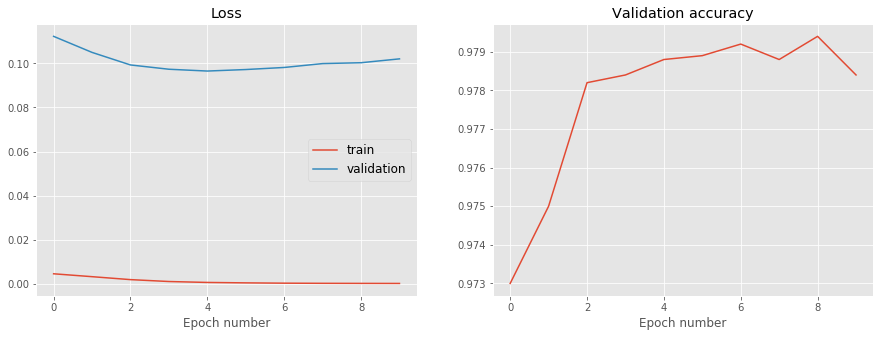

In [104]:
plot_train_process(train_loss, val_loss, val_accuracy)

Print here your accuracy on test set. It should be around 90%.

In [97]:
net.evaluate()
predictions = net.forward(X_test.reshape(len(X_test), -1))
y_pred = np.argmax(predictions, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

In [98]:
print('Test accuracy for the model is {}'.format(test_accuracy))

Test accuracy for the model is 0.9778
